In [1]:
import sys
import os
from datetime import datetime
import json
import shutil
import random
import ast
import numpy as np
import pandas as pd
#import tensorflow as tf
#from tensorflow import keras
from tqdm import tqdm_notebook, tqdm
from matplotlib import pyplot as plt

sys.path.append('../src/')
from env import BTCMarket_Env
from agent import Trader_Agent
from DQNtrainer import DQNTrainer
from DRLtrainer import DRLTrainer
from collections import deque
import h5py
from itertools import product


2023-03-28 17:38:03.860225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
hpo_params= { 
    'obs_space' : [(8,20)], 
    'action_domain' : [(0.0,1.0)], # (-1.0,1.0),
    'money' : [10000], 
    'fee' : [0.001], 
    'asset' : ['BTC', 'PERP'],
#    'reward_function' : ['compute_reward_from_tutor', 'reward_sharpe_ratio', 'reward_sortino_ratio', 
#                        'reward_differential_sharpe_ratio', 'reward_sterling_ratio'],
    'reward_function' : ['compute_reward_from_tutor'],
    
    'learning_rate': [1e-3],
    'trainer' : ['DRLTrainer'], # 'DRLTrainer', 'DQNTrainer'
    'episodes' : [1], 
    'runs_p_eps' : [1], 
    'batch_size': [100],
    'epoch': [5],
    'gamma': [0.95],
    
    'epsilon': [0.7],
    'epsilon_final':[0.01],
    'epsilon_decay':[0.995],
}


keys, values = zip(*hpo_params.items())
hpo_list = [dict(zip(keys, v)) for v in product(*values)]
print(hpo_list)

[{'obs_space': (8, 20), 'action_domain': (0.0, 1.0), 'money': 10000, 'fee': 0.001, 'asset': 'BTC', 'reward_function': 'compute_reward_from_tutor', 'learning_rate': 0.001, 'trainer': 'DRLTrainer', 'episodes': 1, 'runs_p_eps': 1, 'batch_size': 100, 'epoch': 5, 'gamma': 0.95, 'epsilon': 0.7, 'epsilon_final': 0.01, 'epsilon_decay': 0.995}, {'obs_space': (8, 20), 'action_domain': (0.0, 1.0), 'money': 10000, 'fee': 0.001, 'asset': 'PERP', 'reward_function': 'compute_reward_from_tutor', 'learning_rate': 0.001, 'trainer': 'DRLTrainer', 'episodes': 1, 'runs_p_eps': 1, 'batch_size': 100, 'epoch': 5, 'gamma': 0.95, 'epsilon': 0.7, 'epsilon_final': 0.01, 'epsilon_decay': 0.995}]


In [16]:
i = 0
#for i, param_combination in enumerate(hpo_list):
param_combination = hpo_list[0]
if param_combination.get('trainer') == 'DQNTrainer':
    action_space = 4
    algorithm = f'DQN_trial_{i}'
else:
    action_space = 1
    algorithm = f'DRL_trial_{i}'
    
param_combination['action_space'] = action_space
param_combination['algorithm'] = algorithm
print(param_combination)

env = BTCMarket_Env(observation_space = param_combination.get('obs_space', (8,20)),
        action_space = action_space,
        start_money = param_combination.get('money', 10000),
        trading_fee = param_combination.get('fee', (8,20)),
        asset = param_combination.get('asset', 'PERP'),
        reward_function = param_combination.get('reward_function', 'reward_differential_sharpe_ratio'),
                   )

agent = Trader_Agent(observation_space = param_combination.get('obs_space', (8,20)),
            action_space = action_space,
            action_domain=param_combination.get('action_domain', (0.0,1.0)),
            epsilon = param_combination.get('epsilon', 0.7),
            epsilon_final = param_combination.get('epsilon_final', 0.01),
            epsilon_decay = param_combination.get('epsilon_decay', 0.995),
                    )

trainer_class = eval(param_combination.get('trainer', 'DRLTrainer'))
trainer = trainer_class(env, agent,
            observation_space = param_combination.get('obs_space', (8,20)),
            action_space = action_space,
            batch_size=param_combination.get('batch_size', 50),
            epoch=param_combination.get('epoch', 5),
            gamma=param_combination.get('gamma', 0.95),
            learning_rate=param_combination.get('learning_rate', 1e-3),
            algorithm=algorithm,
            lstm_path="./../notebooks/best_models/11_mar_2023/best_model_sequential_20back_10ahead.h5",
            # best_model_sequential_20back_10ahead lstm_2,
                       )

os.makedirs(trainer.train_folder,exist_ok=True)
with open(f'{trainer.train_folder}/params.json', 'w') as fp:
    json.dump(param_combination, fp)
    
trainer.rollout(n_episodes=param_combination.get('episodes', 2), 
                   run_per_episode=param_combination.get('runs_p_eps', 2))

{'obs_space': (8, 20), 'action_domain': (0.0, 1.0), 'money': 10000, 'fee': 0.001, 'asset': 'BTC', 'reward_function': 'compute_reward_from_tutor', 'learning_rate': 0.001, 'trainer': 'DRLTrainer', 'episodes': 1, 'runs_p_eps': 1, 'batch_size': 100, 'epoch': 5, 'gamma': 0.95, 'epsilon': 0.7, 'epsilon_final': 0.01, 'epsilon_decay': 0.995, 'action_space': 1, 'algorithm': 'DRL_trial_0'}
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 20, 8)]      0           []                               
                                                                                                  
 lstm_inputs (Lambda)           (None, 20, 4)        0           ['input_4[0][0]']                
                                                                                                  
 seque

 14%|█▍        | 97/671 [00:02<00:08, 68.74it/s]

Epoch 1/5
4/4 [==============================] - 3s 29ms/step - loss: -1.0204
Epoch 2/5
4/4 [==============================] - 0s 28ms/step - loss: -1.0204
Epoch 3/5
4/4 [==============================] - 0s 28ms/step - loss: -1.0204
Epoch 4/5
4/4 [==============================] - 0s 28ms/step - loss: -1.0204
Epoch 5/5
4/4 [==============================] - 0s 28ms/step - loss: -1.0204
Data saved
episode 1, run (1/1) sample (100/671).Profit 170.15999999999985


 29%|██▉       | 195/671 [00:07<00:09, 48.75it/s]/Users/samuelharck/Desktop/Projekt/ai_trader/notebooks/../src/DRLtrainer.py:286: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.train_log_dataframe = pd.concat([self.train_log_dataframe, tmp])


Data saved
episode 1, run (1/1) sample (200/671).Profit 40.590000000000146
Epoch 1/5
4/4 [==============================] - 0s 29ms/step - loss: -1.0038
Epoch 2/5
4/4 [==============================] - 0s 28ms/step - loss: -1.0038
Epoch 3/5
4/4 [==============================] - 0s 29ms/step - loss: -1.0038
Epoch 4/5
4/4 [==============================] - 0s 29ms/step - loss: -1.0038
Epoch 5/5
4/4 [==============================] - 0s 30ms/step - loss: -1.0038


 44%|████▍     | 298/671 [00:09<00:05, 64.40it/s]/Users/samuelharck/Desktop/Projekt/ai_trader/notebooks/../src/DRLtrainer.py:286: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.train_log_dataframe = pd.concat([self.train_log_dataframe, tmp])


Data saved
episode 1, run (1/1) sample (300/671).Profit -672.2800000000007
Epoch 1/5
4/4 [==============================] - 0s 29ms/step - loss: -0.9667
Epoch 2/5
4/4 [==============================] - 0s 29ms/step - loss: -0.9667
Epoch 3/5
4/4 [==============================] - 0s 30ms/step - loss: -0.9667
Epoch 4/5
4/4 [==============================] - 0s 29ms/step - loss: -0.9667
Epoch 5/5
4/4 [==============================] - 0s 28ms/step - loss: -0.9667


 60%|█████▉    | 400/671 [00:12<00:06, 39.56it/s]/Users/samuelharck/Desktop/Projekt/ai_trader/notebooks/../src/DRLtrainer.py:286: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.train_log_dataframe = pd.concat([self.train_log_dataframe, tmp])


Data saved
episode 1, run (1/1) sample (400/671).Profit -772.8400000000001
Epoch 1/5
4/4 [==============================] - 0s 29ms/step - loss: -0.9203
Epoch 2/5
4/4 [==============================] - 0s 29ms/step - loss: -0.9203
Epoch 3/5
4/4 [==============================] - 0s 29ms/step - loss: -0.9203
Epoch 4/5
4/4 [==============================] - 0s 29ms/step - loss: -0.9203
Epoch 5/5
4/4 [==============================] - 0s 29ms/step - loss: -0.9203


 75%|███████▍  | 500/671 [00:15<00:02, 75.65it/s]/Users/samuelharck/Desktop/Projekt/ai_trader/notebooks/../src/DRLtrainer.py:286: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.train_log_dataframe = pd.concat([self.train_log_dataframe, tmp])


Data saved
episode 1, run (1/1) sample (500/671).Profit -615.8799999999992
Epoch 1/5
4/4 [==============================] - 0s 28ms/step - loss: -0.9272
Epoch 2/5
4/4 [==============================] - 0s 30ms/step - loss: -0.9272
Epoch 3/5
4/4 [==============================] - 0s 29ms/step - loss: -0.9272
Epoch 4/5
4/4 [==============================] - 0s 28ms/step - loss: -0.9272
Epoch 5/5
4/4 [==============================] - 0s 29ms/step - loss: -0.9272


 89%|████████▉ | 599/671 [00:17<00:01, 55.18it/s]/Users/samuelharck/Desktop/Projekt/ai_trader/notebooks/../src/DRLtrainer.py:286: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.train_log_dataframe = pd.concat([self.train_log_dataframe, tmp])


Data saved
episode 1, run (1/1) sample (600/671).Profit -943.8799999999992
Epoch 1/5
4/4 [==============================] - 0s 35ms/step - loss: -0.9182
Epoch 2/5
4/4 [==============================] - 0s 29ms/step - loss: -0.9182
Epoch 3/5
4/4 [==============================] - 0s 28ms/step - loss: -0.9182
Epoch 4/5
4/4 [==============================] - 0s 29ms/step - loss: -0.9182
Epoch 5/5
4/4 [==============================] - 0s 28ms/step - loss: -0.9182


100%|█████████▉| 668/671 [00:20<00:00, 32.22it/s]
/Users/samuelharck/Desktop/Projekt/ai_trader/notebooks/../src/DRLtrainer.py:286: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.train_log_dataframe = pd.concat([self.train_log_dataframe, tmp])


episode 1, finished run (1/1). Run Profit -1028.1200000000008 || money available: [4476.22],  wallet value: [8971.88]
episode 1/1. Profit -1028.1200000000008 || money available: [4476.22],  wallet value: [8971.88]
Data saved


In [11]:
# Plot profit
df = pd.read_csv(f'{trainer.train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

(9, 10)
1.098052740097046


In [12]:
df.head(10)

,Unnamed: 0,episode,run,action,state,reward,done,epsilon,profit,time_elapsed
0,0,1,1,[0.13986059],[[[0.5 0. 0.5 0.5 ...,[1.],False,0.7,-1.00,1.083473
1,1,1,1,[-0.48578792],[[[0.5 0. 0.5 0.5 ...,[1.000085],False,0.7,-1005.89,1.085989
2,2,1,1,[0.07536022],[[[0.5 0. 0.5 0.5 ...,[0.898483],False,0.7,-6004.22,1.087996
3,3,1,1,[-0.98994184],[[[0.5 0. 0.5 0.5 ...,[0.400346],False,0.7,-5996.54,1.090341
4,4,1,1,[-0.6944063],[[[0.5 0. 0.5 0.5 ...,[0.400703],False,0.7,-6905.15,1.092035
5,5,1,1,[-0.32708668],[[[0.5 0. 0.5 0.5 ...,[0.308452],False,0.7,-6917.34,1.093593
6,6,1,1,[-0.80000596],[[[5.00000000e-01 0.00000000e+00 5.00000000e-0...,[0.308289],False,0.7,-6918.65,1.094808
7,7,1,1,[0.96923415],[[[5.00000000e-01 0.00000000e+00 5.00000000e-0...,[0.306924],False,0.7,-9386.79,1.096448
8,8,1,1,[-0.77568499],[[[5.00000000e-01 0.00000000e+00 5.00000000e-0...,[0.063937],True,0.7,-12451.57,1.098053


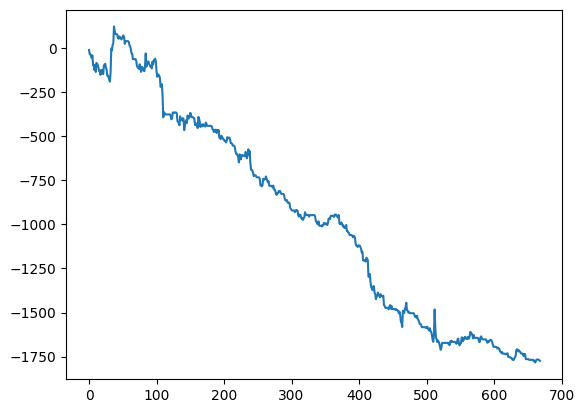

In [6]:
plt.plot(df.profit)

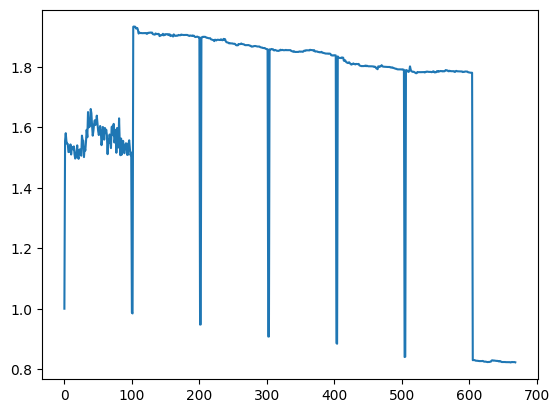

In [7]:
y = [ast.literal_eval(x)[0] for x  in df.reward]
plt.plot(y)

In [17]:
dfep = pd.read_csv(f'/Users/samuelharck/Desktop/Projekt/ai_trader/data/20230328_180031/DRL_trial_0/Epi_1_run_1.csv')

In [22]:
print(dfep.columns)
dfep.head()


Index(['Unnamed: 0', 'long_position', 'episode', 'done', 'btc_eur',
       'swap_price', 'buy_long_count', 'wallet_value', 'btc_price',
       'short_eur', 'reward', 'short_units', 'state', 'sell_long_count',
       'short_position', 'buy_short_count', 'fee_paid', 'action', 'money',
       'long_wallet', 'sell_short_count', 'funding_rate', 'short_wallet',
       'btc_units'],
      dtype='object')


,Unnamed: 0,long_position,episode,done,btc_eur,swap_price,buy_long_count,wallet_value,btc_price,short_eur,...,short_position,buy_short_count,fee_paid,action,money,long_wallet,sell_short_count,funding_rate,short_wallet,btc_units
0,0,0.00,1,False,0,38288.48,0,10000.00,38306.90,-0.0,...,-0.0,0,0,[0],[10000],"[0, 0]",0,-0.000022,"[0, 0]",0
1,1,0.70,1,False,[6995.1034276],38304.67,1,9993.00,38338.75,-0.0,...,-0.0,0,[6.99510343],[0.7],[2997.9],"[array([0.18261751]), array([38304.67])]",0,-0.000022,"[0, 0]",[0.18261751]
2,2,0.40,1,False,[4000.68040558],38261.99,1,9982.22,38277.55,-0.0,...,-0.0,0,[2.99442302],[0.4],[5989.33],"[array([0.10435647]), array([38336.67741651])]",0,-0.000022,"[0, 0]",[0.10435647]
3,3,0.41,1,False,[4000.68040558],39147.03,1,10074.58,39178.13,-0.0,...,-0.0,0,0,[0.4],[5989.33],"[array([0.10435647]), array([38336.67741651])]",0,-0.000022,"[0, 0]",[0.10435647]
4,4,0.80,1,False,[7973.5949128],39066.74,2,10062.22,39086.74,-0.0,...,-0.0,0,[3.97291451],[0.8],[2012.44],"[array([0.20605204]), array([38696.99479512])]",0,-0.000022,"[0, 0]",[0.20605204]


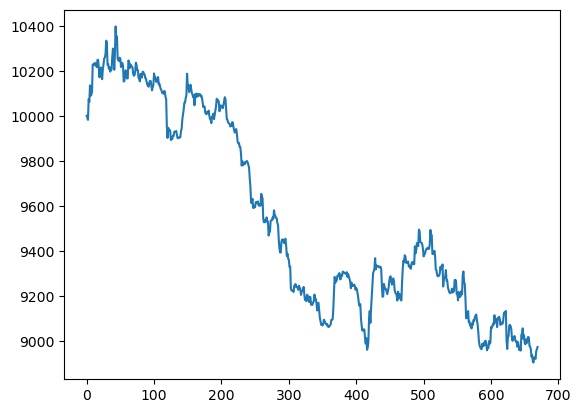

In [21]:
plt.plot(dfep.wallet_value)